# Apr ??, 2022 ()

**Motivation**: Make group plots (KABA) <br>

In [1]:
# HIDE CODE


import os
import sys
import nibabel as nib
import networkx as nx
from time import time
from pprint import pprint
from copy import deepcopy as dc
from os.path import join as pjoin
from numpy.ma import masked_where as mwh
from scipy.ndimage import gaussian_filter
from IPython.display import display, IFrame, HTML
from matplotlib.colors import rgb2hex, to_rgb
import matplotlib.pyplot as plt
import seaborn as sns

# set style & no interpolalation
import matplotlib
matplotlib.rcParams['image.interpolation'] = 'none'
sns.set_style('whitegrid')
%matplotlib inline

# tmp & extras dir
git_dir = pjoin(os.environ['HOME'], 'Dropbox/git')
tmp_dir = pjoin(git_dir, 'jb-Ca-fMRI/tmp')
fig_dir = pjoin(git_dir, 'jb-Ca-fMRI/figs')
extras_dir = pjoin(git_dir, 'jb-Ca-fMRI/_extras')
lfr_dir = pjoin(os.environ['HOME'], 'Documents/workspaces/lfr/binary_overlapping')


# GitHub
sys.path.insert(0, pjoin(git_dir, '_Ca-fMRI'))
from register.atlas import make_tree_graph
from register.parcellation import Parcellation
from analysis.hierarchical import Hierarchical
from analysis.fourier import *
from analysis.bootstrap import *
from analysis.svinet import *
from analysis.group import *
from analysis.lfr import *
from utils.render import *
from utils.plotting import *
from model.mouse import Mice
from model.configuration import Config

# warnings
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

In [2]:
def quick_show(tr1, tr2, vmin=0.1, vmax=None, cmap='magma'):
    num = max(len(tr1['proj-top']), len(tr2['proj-top']))
    fig, axes = create_figure(2, num, (13, 4))
    for i in range(num):

        ax = axes[0, i]
        if i >= len(tr1['proj-top']):
            ax.remove()
        else:
            ax.imshow(mwh(tr1['top'] == 0, tr1['top']), cmap='Greys_r')
            if np.nanmax(tr1['proj-top'][i]) > 1:
                _cmap = 'Accent_r'
                _vmax = None
            else:
                _cmap = cmap
                _vmax = vmax
            ax.imshow(mwh(tr1['proj-top'][i] < vmin, tr1['proj-top'][i]), cmap=_cmap, vmin=vmin, vmax=_vmax)

        ax = axes[1, i]
        if i >= len(tr2['proj-top']):
            ax.remove()
        else:
            ax.imshow(mwh(tr2['top'] == 0, tr2['top']), cmap='Greys_r')
            if np.nanmax(tr2['proj-top'][i]) > 1:
                _cmap = 'Accent_r'
                _vmax = None
            else:
                _cmap = cmap
                _vmax = vmax
            ax.imshow(mwh(tr2['proj-top'][i] < vmin, tr2['proj-top'][i]), cmap=_cmap, vmin=vmin, vmax=_vmax)

    remove_ticks(axes)
    plt.show()

## Fig dir

In [3]:
fig_kws = {
    'transparent': True,
    'bbox_inches': 'tight',
}
fig_dir = pjoin(fig_dir, 'paper')
os.makedirs(fig_dir, exist_ok=True)

## Prepare

In [14]:
mice = Mice((128, 3))
mice.setup_func_data('rest')

mako = sns.color_palette('mako', as_cmap=True)
rocket = sns.color_palette('rocket', as_cmap=True)
pal = {'ca2': mako(0.6), 'bold': rocket(0.6)}

num_k, p = 7, 20
perc = f'p{p}-binary'
props_base = {
    'perc': perc,
    'num_k': num_k,
    'mice': mice,
    'task': 'rest',
    'metric': 'pearson',
    'match_using': 'gam',
    'match_metric': 'euclidean',
    'graph_type': 'real',
    'verbose': False,
}
props_ca = {'mode': 'ca2', **props_base}
props_bo = {'mode': 'bold', **props_base}

In [15]:
%%time

# gr_ca = Group(**props_ca).fit_group(force=True)
gr_bo = Group(**props_bo).fit_group(force=True)

CPU times: user 14min, sys: 31.8 s, total: 14min 32s
Wall time: 2min 28s


In [16]:
# gr_ca = Group(**props_ca).fit_group()
gr_bo = Group(**props_bo).fit_group()

In [17]:
# gr_ca.pi = bn.nanmean(bn.nanmean(bn.nanmean(bn.nanmean(gr_ca.run_pi, 3), 2), 1), 0)
gr_bo.pi = bn.nanmean(bn.nanmean(bn.nanmean(bn.nanmean(gr_bo.run_pi, 3), 2), 1), 0)

In [8]:
# proj_bo = gr_bo.project_vec()
# proj_ca = gr_ca.project_vec()

In [18]:
pi_sfc = gr_bo.get_surface_pi()
proj_avg = gr_bo.project_vec(pi_sfc, layer=0)
proj_0 = gr_bo.project_vec(layer=0)
proj_1 = gr_bo.project_vec(layer=1)
proj_2 = gr_bo.project_vec(layer=2)

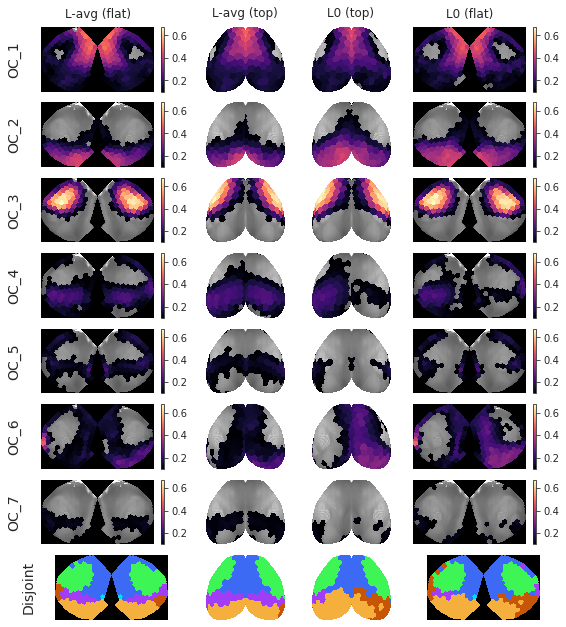

In [19]:
## p20-binary

_ = gr_bo.show(
    proj_1=proj_avg,
    proj_2=proj_0,
    cmaps=('magma',) * 2,
    labels=('L-avg', 'L0'),
    fix_cmap=True,
    min_thres=0.1,
)

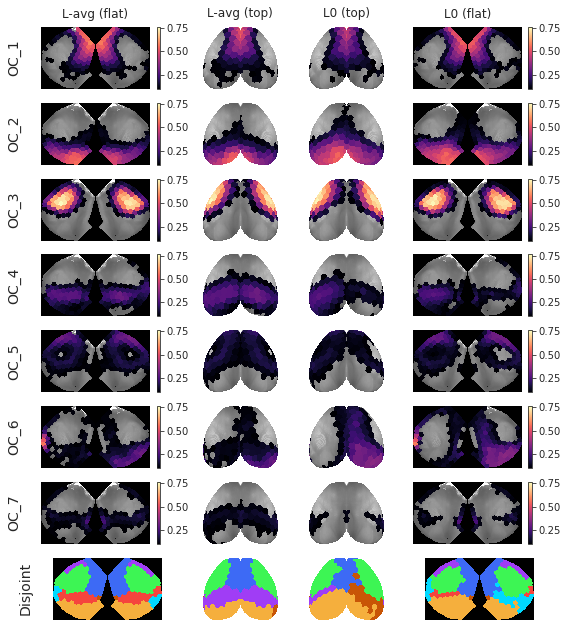

In [10]:
## p10-sample

_ = gr_bo.show(
    proj_1=proj_avg,
    proj_2=proj_0,
    cmaps=('magma',) * 2,
    labels=('L-avg', 'L0'),
    fix_cmap=True,
    min_thres=0.1,
)

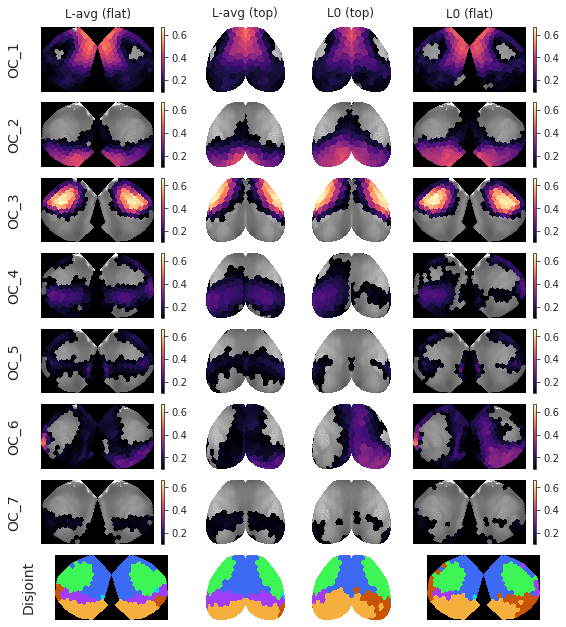

In [9]:
## p25-sample

_ = gr_bo.show(
    proj_1=proj_avg,
    proj_2=proj_0,
    cmaps=('magma',) * 2,
    labels=('L-avg', 'L0'),
    fix_cmap=True,
    min_thres=0.1,
)

In [20]:
vol = np.zeros((gr_bo.num_k, *mice.parcel['cortex'].shape), dtype=float)

for node, lbl in gr_bo.n2l.items():
    ii = mice.parcel.encode(lbl)
    if len(lbl.split('-')) == 3:
        m = mice.parcel['cortex'] == ii
    else:
        m = mice.parcel['subcortex'] == ii
    if int(lbl.split('-')[0]) == 1:
        m *= mice.al.mask_l
    else:
        m *= mice.al.mask_r
    for i in range(gr_bo.num_k):
        vol[i][m] = gr_bo.pi[i, node]

In [21]:
mice.al.load_everything(100)

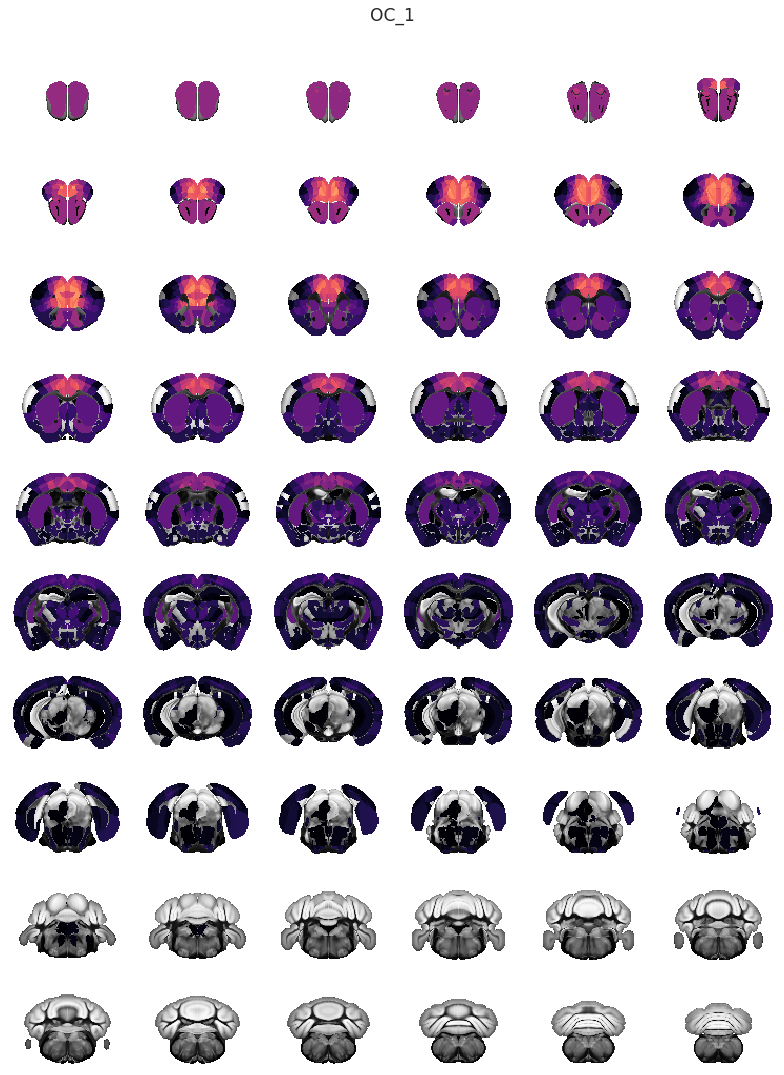

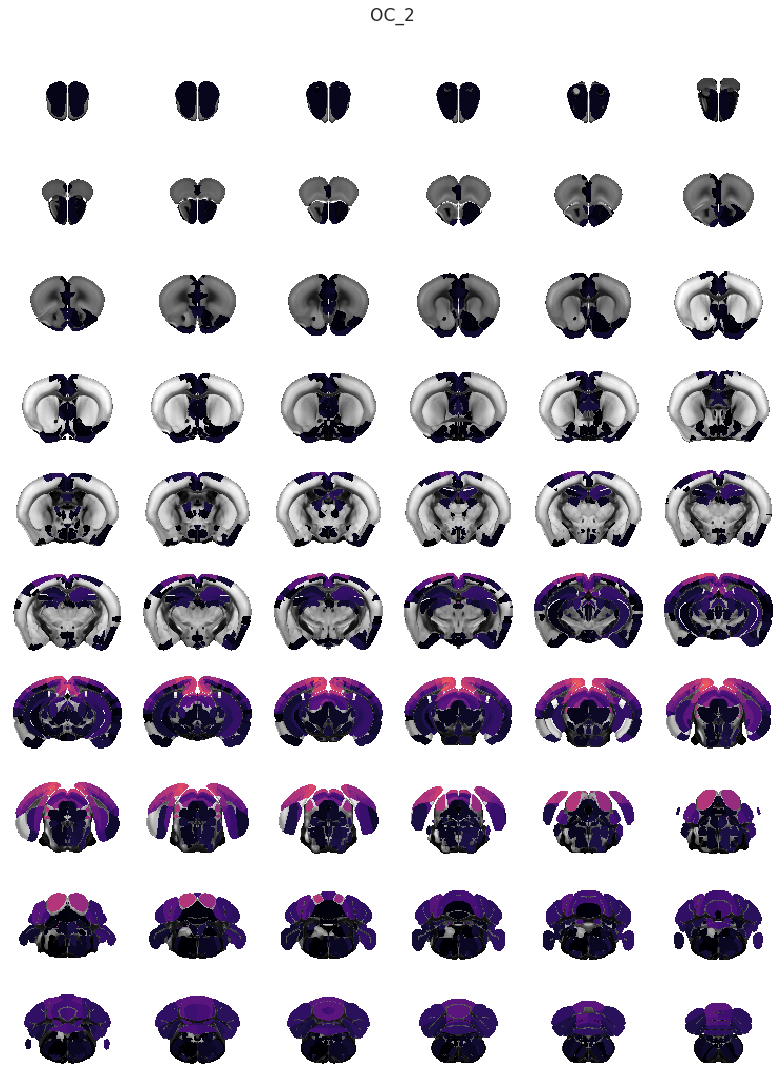

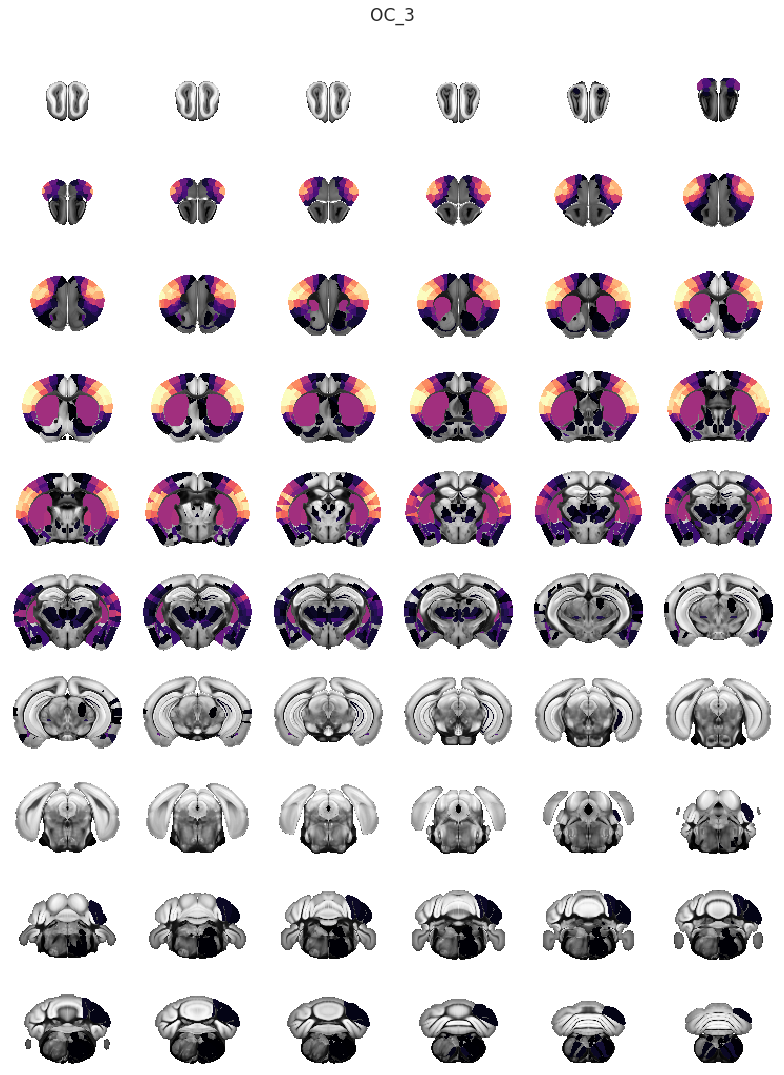

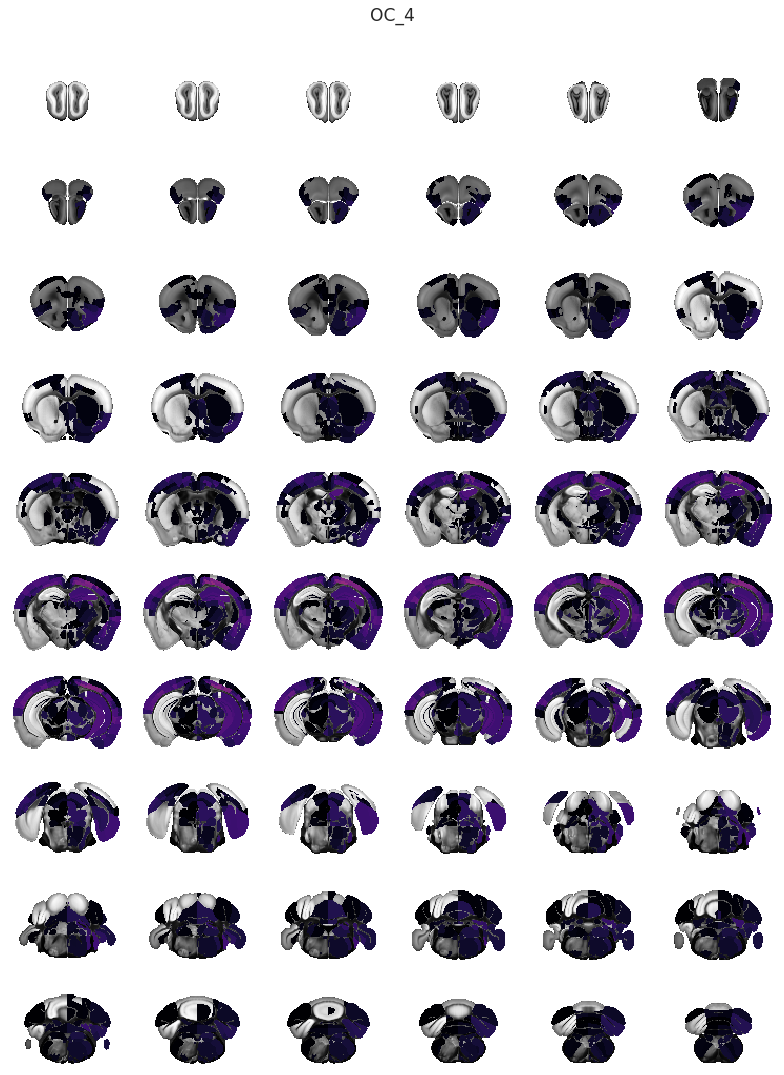

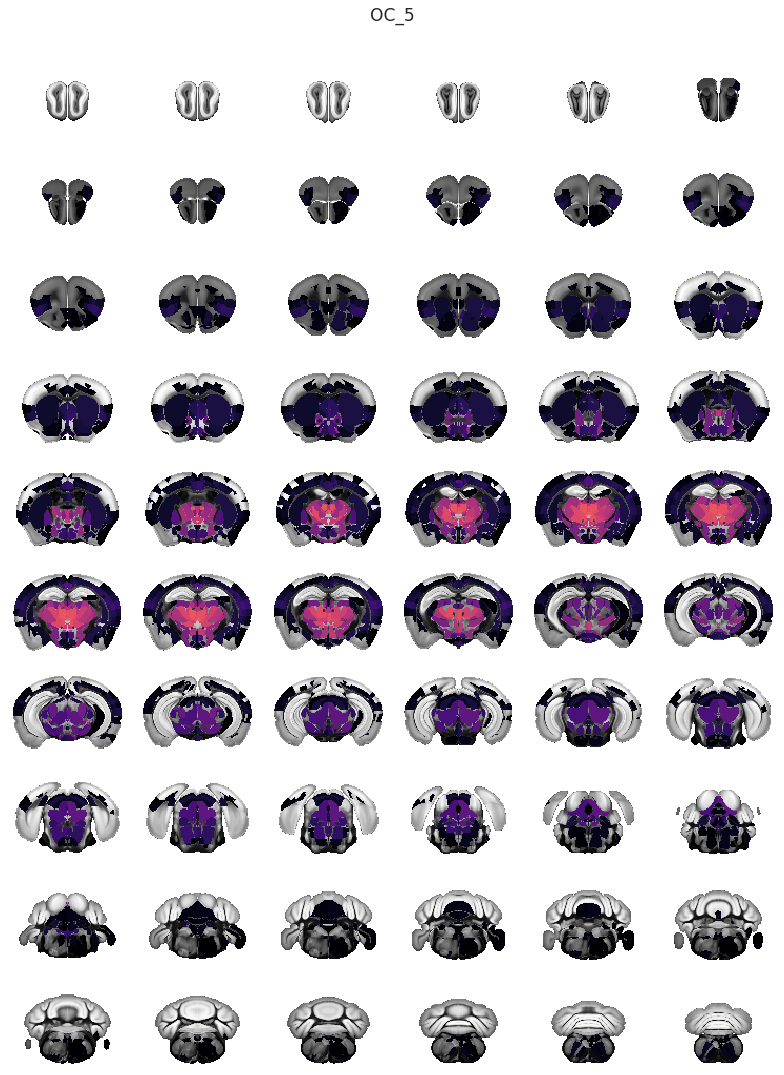

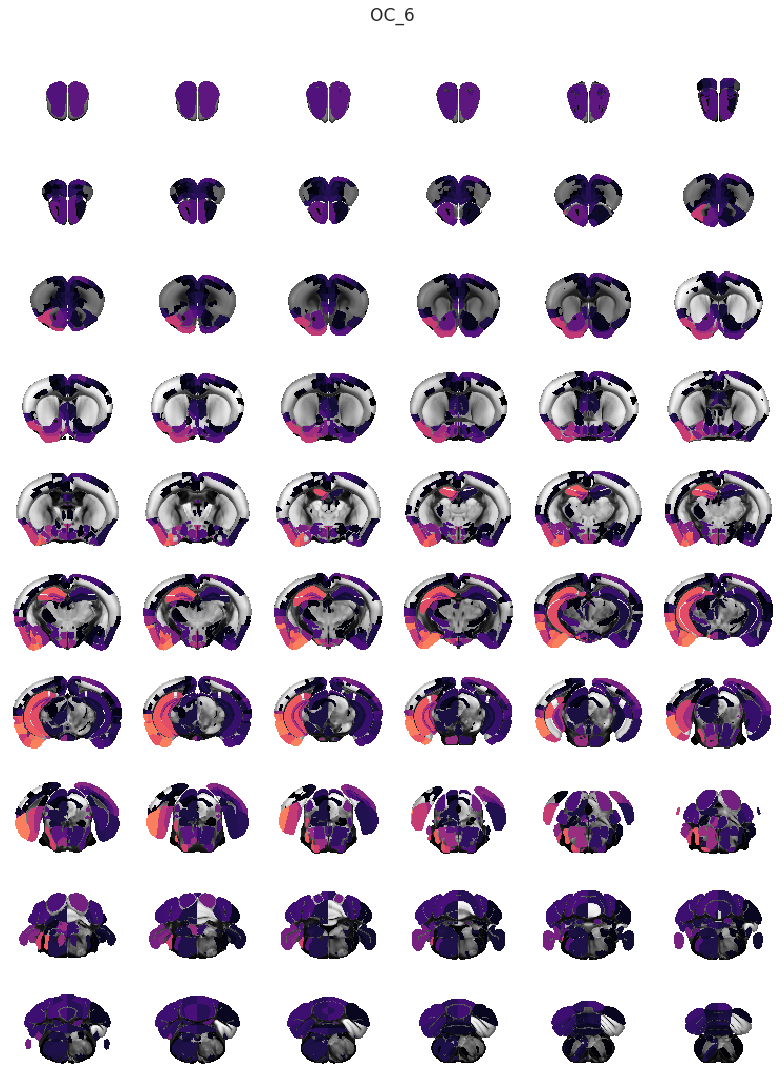

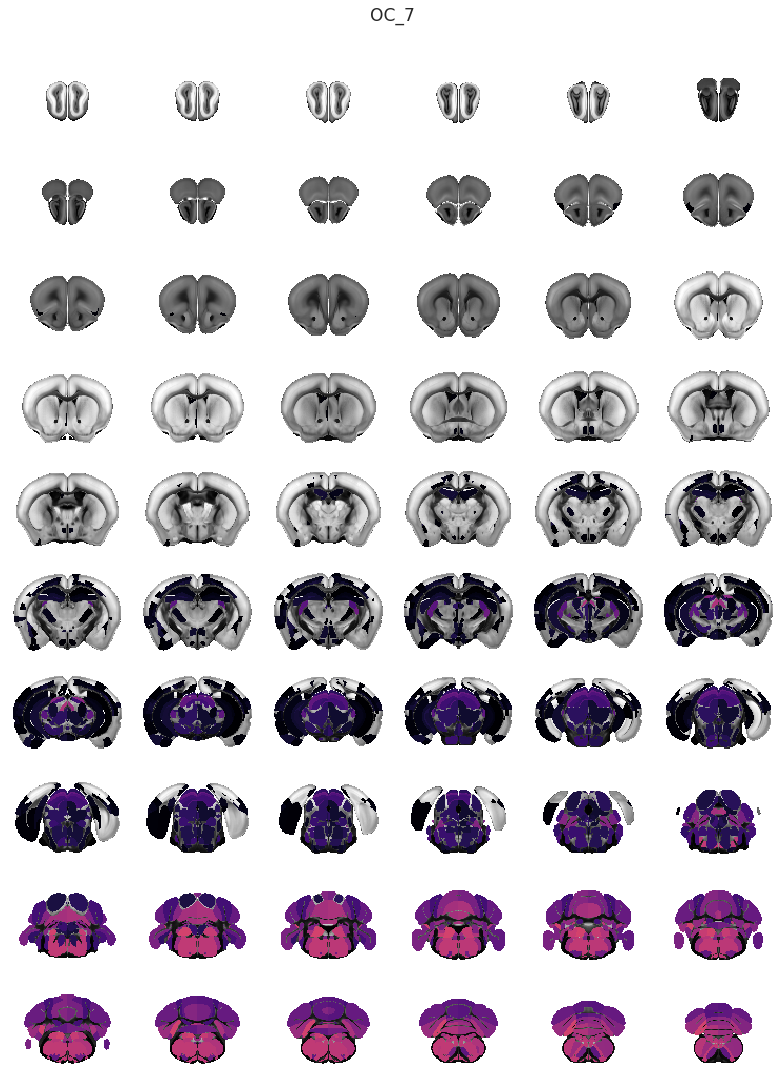

In [24]:
vmin = thres = 0.1
vmax = 0.65
for oc_i in range(gr_bo.num_k):
    fig, axes = create_figure(10, 6, (11, 15))
    # vmax = np.max(vol[oc_i])
    for i, jj in enumerate(range(10, 130, 2)):
        ax = axes.flat[i]
        ax.imshow(mwh(mice.al.annotation[jj] == 0, mice.al.template[jj]), cmap='Greys_r')
        ax.imshow(mwh(vol[oc_i][jj] < thres, vol[oc_i][jj]), vmin=vmin, vmax=vmax, cmap='magma')
    fig.suptitle(f"OC_{oc_i+1}", fontsize=17, y=1.0)
    remove_ticks(axes)
    plt.show()
    
    print('\n\n')

In [37]:
pi = gr_bo.grp_pi.copy()
pi[1][pi[1] < 0.1] = 0
pi[-1][pi[-1] < 0.1] = 0
pi[1] += pi[-1]
pi = pi[:-1]
tr = gr_bo.project_vec(pi)
tr = gr_bo.trim2d(tr)

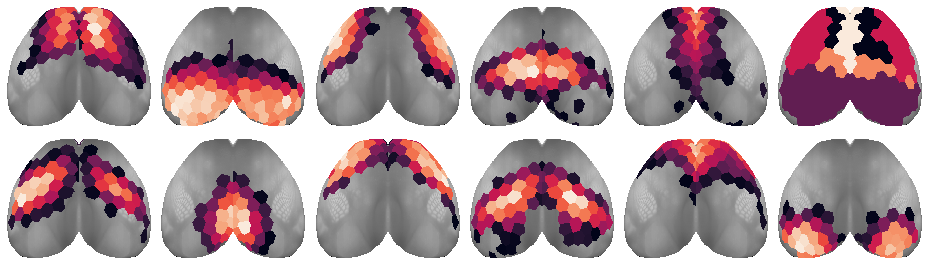

In [38]:
quick_show(tr, gr_ca.trim2d(proj_ca), .15)

In [54]:
props_ca['num_k'] = 6
gr_ca = Group(**props_ca).fit_group()
tr_ca = gr_ca.project_vec(gr_ca.grp_pi)
tr_ca = gr_ca.trim2d(tr_ca)

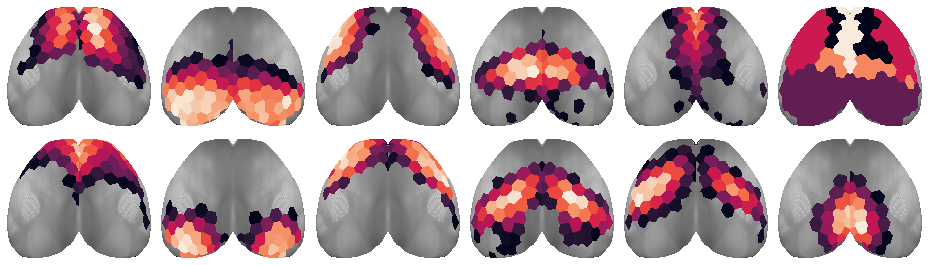

In [55]:
quick_show(tr, tr_ca, .15)

In [56]:
sim = dist2sim(sp_dist.cdist(pi, gr_ca.grp_pi, 'correlation'))
ids = list(find_best_match(sim).values())
ids

[4, 1, 2, 3, 0]

In [57]:
ids = ids + [5]

In [58]:
gr_ca.pi = gr_ca.grp_pi[ids]
tr_ca = gr_ca.project_vec()
tr_ca = gr_ca.trim2d(tr_ca)

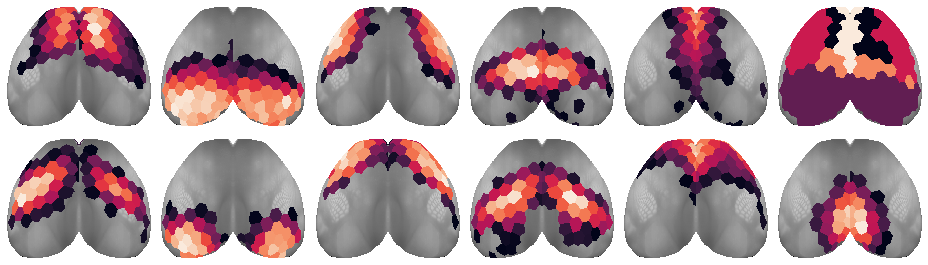

In [59]:
quick_show(tr, tr_ca, .15)

In [60]:
sim = dist2sim(sp_dist.cdist(pi, gr_ca.pi, 'correlation'))

<AxesSubplot:>

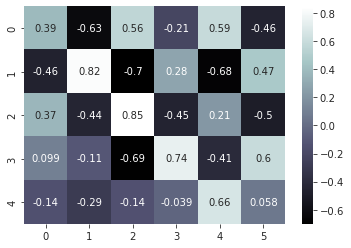

In [61]:
sns.heatmap(sim, cmap='bone', square=True, annot=True)

[4, 1, 2, 3, 0]

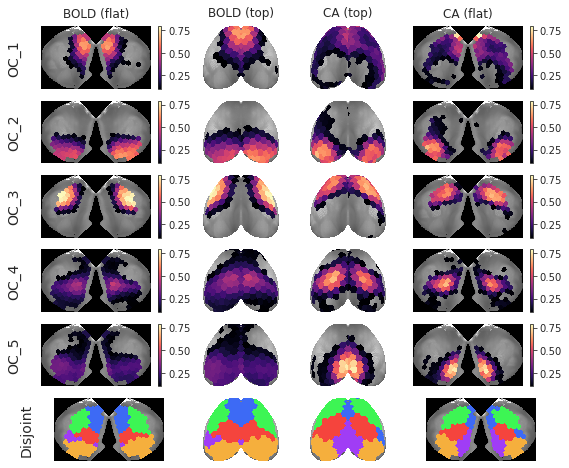

In [5]:
_ = gr_ca.show(
    proj_1=proj_bo,
    proj_2=proj_ca,
    cmaps=('magma',) * 2,
    labels=('BOLD', 'CA'),
    fix_cmap=True,
    min_thres=0.10,
)

In [9]:
props_ca['perc'] = 'p25-sample'
props_bo['perc'] = 'p25-sample'

In [4]:
gr_ca = Group(**props_ca).fit_group(force=True, n_top=0)
gr_bo = Group(**props_bo).fit_group(force=True, n_top=0)

[PROGRESS] 'se_indiv-pi_1.0e+02.npy' saved at
/home/hadi/Documents/Ca-fMRI/processed/norm-global_parcel-columnar_n-128*3/results/SVINET/Gro
up/real_pearson_ca2_k5_p25-sample

[PROGRESS] 'se_indiv-pi_1.0e+02.npy' saved at
/home/hadi/Documents/Ca-fMRI/processed/norm-global_parcel-columnar_n-128*3/results/SVINET/Gro
up/real_pearson_bold-lite_k5_p25-sample

In [4]:
gr_ca = Group(**props_ca).fit_group()
gr_bo = Group(**props_bo).fit_group()

sim = dist2sim(sp_dist.cdist(
    XA=gr_bo.grp_pi,
    XB=gr_ca.grp_pi,
    metric='correlation',
))
mapping = find_best_match(sim)
ids = list(mapping.values())

gr_bo.pi = gr_bo.grp_pi
gr_ca.pi = gr_ca.grp_pi[ids]

ids

[0, 1, 2, 3, 4]

In [ ]:
pi_sfc = gr_bo.get_surface_pi()
pi_sfc
pi_sfc.shape

BOLD (cos)   : : :   ovp: 0.9931,  disj: 0.9533

Ca2  (cos)   : : :   ovp: 0.9900,  disj: 0.9429

BOLD (corr)   : : :   ovp: 0.9718,  disj: 0.9533

Ca2  (corr)   : : :   ovp: 0.9774,  disj: 0.9429

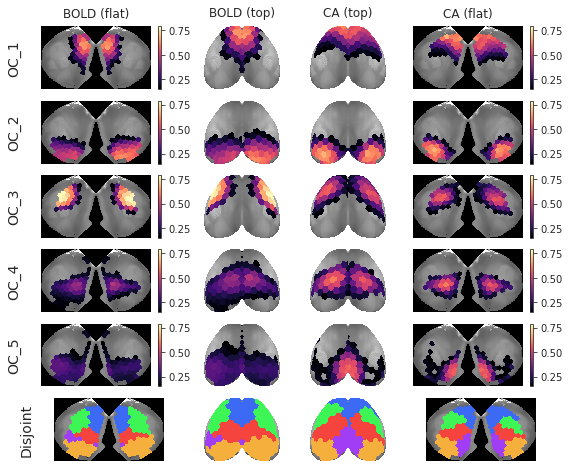

In [7]:
proj_bo = gr_bo.project_vec()
proj_ca = gr_ca.project_vec()

ovp, disj = gr_bo.pi_symmetry_score(decimals=5, metric='cosine')
print(f"BOLD (cos)   : : :   ovp: {ovp[-1]:0.4f},  disj: {disj[-1]:0.4f}")
ovp, disj = gr_ca.pi_symmetry_score(decimals=5, metric='cosine')
print(f"Ca2  (cos)   : : :   ovp: {ovp[-1]:0.4f},  disj: {disj[-1]:0.4f}")

ovp, disj = gr_bo.pi_symmetry_score(decimals=5, metric='correlation')
print(f"BOLD (corr)   : : :   ovp: {ovp[-1]:0.4f},  disj: {disj[-1]:0.4f}")
ovp, disj = gr_ca.pi_symmetry_score(decimals=5, metric='correlation')
print(f"Ca2  (corr)   : : :   ovp: {ovp[-1]:0.4f},  disj: {disj[-1]:0.4f}")

_ = gr_ca.show(
    proj_1=proj_bo,
    proj_2=proj_ca,
    cmaps=('magma',) * 2,
    labels=('BOLD', 'CA'),
    min_thres=0.15,
)

In [8]:
sim = dist2sim(sp_dist.cdist(gr_bo.pi, gr_ca.pi, metric='correlation')).diagonal()
sim.mean(), sim

(
    0.8045905642503733,
    array([0.77256247, 0.87611373, 0.90864038, 0.8775671 , 0.58806914])
)

In [14]:
sim = dist2sim(sp_dist.cdist(gr_bo.pi, gr_ca.pi, metric='correlation')).diagonal()
sim.mean(), sim

(
    0.7619878878106711,
    array([0.79168126, 0.86979172, 0.92683994, 0.83400457, 0.38762197])
)

BOLD   : : :   ovp: 0.9931,  disj: 0.9533

Ca2    : : :   ovp: 0.9900,  disj: 0.9429

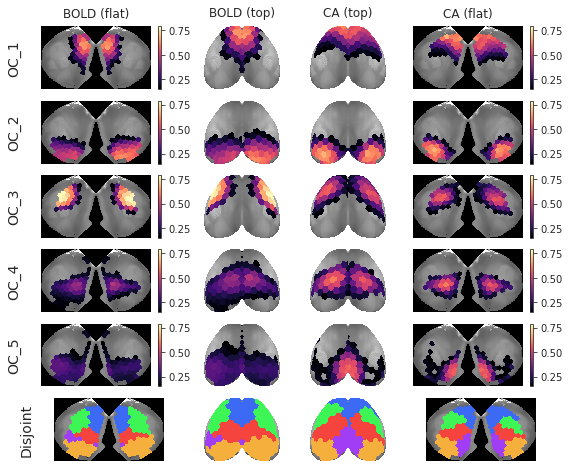

array([0.89759295, 0.93812407, 0.93647299, 0.93802766, 0.86423032])

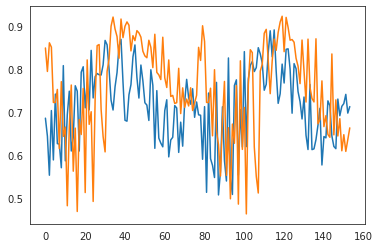

In [22]:
h = np.concatenate([np.expand_dims(gr_ca.grp_h, 0), np.expand_dims(gr_bo.grp_h, 0)])
plt.plot(h[0])
plt.plot(h[1]);

In [23]:
proj = gr_ca.project_vec(h, add_disjoint=False)
tr = gr_ca.trim2d(proj)

In [24]:
vmin = np.nanmin(tr['proj-top'][tr['proj-top'].nonzero()])
vmax = np.nanmax(tr['proj-top'][tr['proj-top'].nonzero()])
vmin, vmax

(0.46224414488975507, 0.9232122642849067)

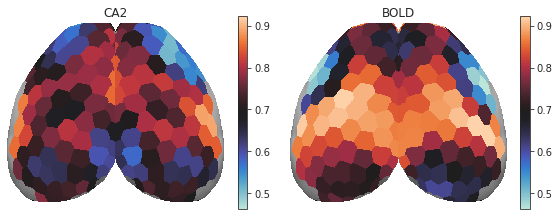

In [25]:
cmap = 'icefire'

fig, axes = create_figure(1, 2, (8, 3))
for ax in axes.flat:
    ax.imshow(mwh(tr['top'] == 0, tr['top']), cmap='Greys_r')
im = axes[0].imshow(mwh(tr['proj-top'][0] == 0, tr['proj-top'][0]), cmap=cmap, vmin=vmin, vmax=vmax)
plt.colorbar(im, ax=axes[0])
axes[0].set_title('CA2')
im = axes[1].imshow(mwh(tr['proj-top'][1] == 0, tr['proj-top'][1]), cmap=cmap, vmin=vmin, vmax=vmax)
plt.colorbar(im, ax=axes[1])
axes[1].set_title('BOLD')

remove_ticks(axes)
plt.show()

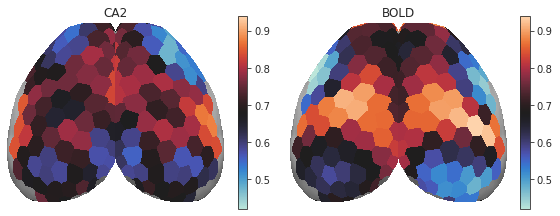

In [26]:
np.nanmax(gr_bo.run_h)

1.1600678099495998

In [14]:
np.where(gr_bo.run_h == np.nanmax(gr_bo.run_h))

(array([3, 3]), array([0, 0]), array([2, 2]), array([46, 47]))

In [15]:
gr_bo.run_h[3, 0, 2]

memmap([0.71320275, 0.69312953, 1.09754894, 0.64126607, 0.87871521,
        0.485734  , 0.55498702, 0.65078985, 0.62387195, 0.63271541,
        0.8798883 , 0.80231723, 0.47001186, 0.5968465 , 0.6866903 ,
        0.58634956, 0.67959686, 0.70769929, 0.60257661, 0.81507713,
        0.61179007, 0.77589851, 0.70691357, 0.629091  , 0.59238888,
        0.65745126, 0.91709804, 0.81379251, 0.59836769, 0.5756306 ,
        0.56720258, 0.69030796, 0.60020893, 0.78689179, 0.70958667,
        0.55644272, 0.53600768, 0.63205321, 0.54688092,        nan,
        0.99586822, 0.69267119, 0.56236773, 0.7130031 , 0.53732076,
        0.54922194, 1.16028802, 1.16028802, 1.00435786, 0.56403627,
        0.53606003, 0.58192178, 0.46127951, 1.01175578, 0.57775628,
        0.57526951, 0.56798097, 0.61422719, 0.69720302, 0.55481447,
        0.58019522, 0.83379799, 1.05131615, 0.70747793, 0.74026226,
        0.59064957, 0.62390361, 0.52537374, 0.96287323, 0.68118029,
        0.85907195, 0.78626667, 0.86639006, 0.65961604, 0.72023512,
        0.69212539, 0.6880553 , 0.6604456 , 0.58225972, 0.9546752 ,
        0.61798952, 0.62352893, 0.38667467, 0.65013914,        nan,
        0.94534586, 0.58215547, 0.72410356, 0.8610189 , 0.5071053 ,
        0.69736315, 0.66449118, 0.61196331, 0.60364488, 0.56705562,
        0.60285937, 0.59493677, 0.663222  , 0.72222596, 0.70371705,
        0.63285346, 0.59086805, 0.66440086, 0.72852126, 0.73233486,
        0.69094584, 0.56750941, 0.56053122, 0.66209945, 0.71710452,
        0.83113222, 0.78990438, 0.6281358 , 0.61732922, 0.65788915,
        0.70445682, 1.00214772, 0.9687276 , 0.70330976, 0.67128062,
        0.49446425, 0.70580024, 0.80310595, 1.06187256, 1.14889813,
        0.69782734, 0.741683  , 0.38950811, 0.58113627, 0.4894412 ,
        0.22152928, 0.19939259, 0.7628918 , 0.1277853 , 0.12829611,
        0.15756138, 0.42615582, 0.17941369, 0.14015762, 0.36625414,
        0.12547698, 0.12620923, 0.14245315, 0.12990778, 0.8821978 ,
        0.23626053, 0.79320708, 0.29013171, 0.20560188, 0.18694904,
        0.12440494, 0.33178769, 0.72341648, 0.4541855 ])

In [18]:
a = gr_bo.run_pi_prune[3, 0, 2]
a.shape

(5, 154)

In [20]:
a[:, 46:49]

memmap([[0.        , 0.25798788, 0.        ],
        [0.        , 0.23775546, 0.        ],
        [0.        , 0.        , 0.        ],
        [0.50421348, 0.25425301, 0.22089012],
        [0.49578652, 0.25000365, 0.77910988]])

In [21]:
b = sp_stats.entropy(gr_bo.run_pi[8, 2, 1], axis=0) / np.log(5)

<AxesSubplot:ylabel='Count'>

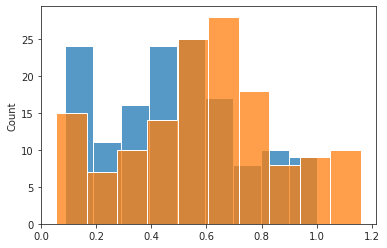

In [23]:
sns.histplot(b)
sns.histplot(gr_bo.run_h[8, 2, 1], color='C1')